<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This file is adapted from a notebook created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> (available <a href="https://www.audiolabs-erlangen.de/resources/MIR/FMP/C8/C8S3_NMFbasic.html">here</a>) that was published along with the book  <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/bookFMP"> Fundamentals of Music Processing</a>.</div> 

# Activity #1 - NMF on a toy example

##  IS-NMF multiplicative update rules

In the following code cell, you have to complete a function that implements the multiplicative update rules for NMF with the Itakura-Saito divergence, as studied in the lesson.

In [ ]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import IPython.display as ipd
%matplotlib inline

In [ ]:
def IS_div(V, V_hat):
    """
    Returns the IS divergence between V and V_hat.
    """
    F, N = V.shape
    return np.sum( V/(V_hat) - np.log(V/V_hat) - np.ones((F,N)) )/(F*N)

def IS_NMF(V, K, niter=1000, W=None, H=None, verbose=False):
    """NMF algorithm with Itakura-Saito divergence
    
    Args: 
        V: Nonnegative matrix of size F x N
        K: Rank of the factorization
        niter: Number of iterations
        W: Nonnegative matrix of size F x K used for initialization
        H: Nonnegative matrix of size K x N used for initialization
        verbose (bool): Prints errors during runtime
    
    Returns: 
        W: Nonnegative matrix of size F x K
        H: Nonnegative matrix of size K x N
        V_hat: Nonnegative matrix W*H of size F x N
        cost: history of the IS divergence
    """ 
    
    eps=1e-10 # used for numerical stability (to avoid division by zero for instance)
    F, N = V.shape
    
    if W is None:
        # initialize W
        W = np.maximum(np.random.rand(F,K), eps)
        
    if H is None: 
        # initialize H
        H = np.maximum(np.random.rand(K,N), eps)
    
    # compute V_hat
    V_hat = W@H + eps
    
    # initialize array for computing the IS divergence
    cost = np.zeros((niter,))
    
    # main loop
    for n in np.arange(niter):
        
        # update W
        # TO COMPLETE        
        W = W * ( ( ( V/(V_hat**2) )@H.T + eps) / ( (1/V_hat)@H.T + eps ) )**.5
        
        # compute V_hat
        V_hat = W@H + eps
        
        # Update H
        # TO COMPLETE
        H = H * ( ( W.T@( V/(V_hat**2) ) + eps) / ( W.T@(1/V_hat) + eps ) )**.5
        
        # compute V_hat
        V_hat = W@H + eps
        
        # compute IS divergence
        cost[n] = IS_div(V, V_hat)
        
        # print IS divergence
        if verbose:
            print('IS-NMF: iteration %d / %d, cost=%f\n' % (n, niter, cost[n]))
    
    return W, H, V_hat, cost

### Application on a toy example

Let's first import some functions to plot the results of NMF.

In [ ]:
def power_to_db(V, amin=1e-10, top_db=80.0):
    """
    Taken from https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
    
    Essentially computes a power spectrogram in dB.
    """
    
    ref = np.max(V)
    V_dB = 10.0 * np.log10(np.maximum(amin, V))
    V_dB -= 10.0 * np.log10(np.maximum(amin, ref))
    V_dB = np.maximum(V_dB, V_dB.max() - top_db)
    return V_dB

def amp_to_db(V, amin=1e-10, top_db=80.0):
    """
    Taken from https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
    
    Essentially computes a power spectrogram in dB.
    """
    return power_to_db(V**2, amin, top_db)
    
def plot_NMF(V, W, H, V_hat, error, figsize=(10,2), aspect='auto', wr=[1, 0.5, 1, 1], power_spec=False): 
    """
    Plot NMF.
    
    Args:
        'V': the original data matrix
        'W': the dictionary matrix
        'H': the activation matrix
        'V_hat': the reconstructed data matrix
        'error': value of the IS divergence that will be put in the title of the plot.
        'figsize': size of the figure
        'aspect': controls the aspect ratio of the axes (see matplotlib.axes.Axes.imshow)
        'wr': width ratios of the columns.
        'power_spec': must be set to True if V corresponds to a power spectrogram.
    
    """
    if power_spec:
        V = power_to_db(V)
        V_hat = power_to_db(V_hat)
        W = power_to_db(W)
        H = H**(1/4) # reduces the dynamic for better visualization
    
    fig, ax = plt.subplots(1, 4, gridspec_kw={'width_ratios': wr}, figsize=figsize)    
    
    K = W.shape[1]
    cmap = 'gray_r'
    # im = ax[0].imshow(V, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(V)])
    im = ax[0].imshow(V, aspect=aspect, origin='lower', cmap=cmap)
    ax[0].set_title(r'$V$')
    plt.sca(ax[0])
    plt.colorbar(im)   
    # im = ax[1].imshow(W, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(W)])
    im = ax[1].imshow(W, aspect=aspect, origin='lower', cmap=cmap)
    ax[1].set_title(r'$W$')
    plt.sca(ax[1])
    plt.colorbar(im)
    plt.xticks(np.arange(K), np.arange(1, K+1))
    # im = ax[2].imshow(np.flip(H, axis=0), aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(H)])
    im = ax[2].imshow(np.flip(H, axis=0), aspect=aspect, origin='lower', cmap=cmap)
    ax[2].set_title(r'$H$')
    plt.sca(ax[2])    
    plt.colorbar(im)
    plt.yticks(np.arange(K), np.arange(K, 0, -1))
    # im = ax[3].imshow(V_hat, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(V_hat)])
    im = ax[3].imshow(V_hat, aspect=aspect, origin='lower', cmap=cmap)
    ax[3].set_title(r'$WH$ (error = %0.2f)'%error)
    plt.sca(ax[3])    
    plt.colorbar(im)
    plt.tight_layout() 
    plt.show() 

We illustrate the functioning of the NMF procedure by means of a small toy example $V \in \mathbb{R}_{+}^{F \times N}$ with $F=4$ and $N=8$. The rank parameter is set to $K=2$. You will see that different runs lead to very different decompositions. This is because initialization is very important for iterative algorithms used to solve non-convex optimization problems. 

Matrix V and randomly initialized matrices W and H


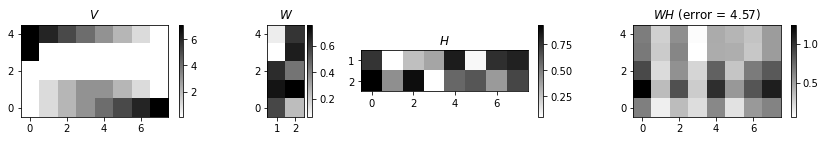

Matrix V and matrices W and H after training


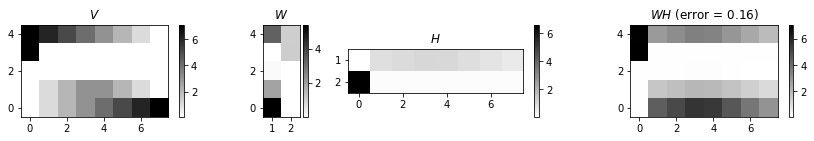

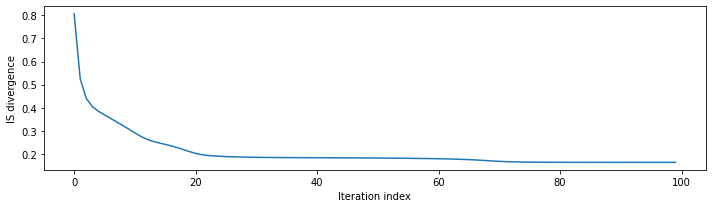

In [ ]:
V = np.array([ 
    [0, 1, 2, 3, 4, 5, 6, 7], 
    [0, 1, 2, 3, 3, 2, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0], 
    [7, 0, 0, 0, 0, 0, 0, 0], 
    [7, 6, 5, 4, 3, 2, 1, 0]    
             ],dtype=float) + .1

F, N = V.shape
K = 2
niter = 100

W_init = np.abs(np.random.rand(F,K))
H_init = np.abs(np.random.rand(K,N))

print('Matrix V and randomly initialized matrices W and H')
V_hat = W_init @ H_init
error = IS_div(V, V_hat)
plot_NMF(V, W_init, H_init, V_hat, error, figsize=(12,2), aspect='equal', wr=[1, 0.3, 1, 1])

print('Matrix V and matrices W and H after training')
W, H, V_hat, cost = IS_NMF(V, K, niter=niter, W=W_init, H=H_init, verbose=False)
plot_NMF(V, W, H, V_hat, cost[-1], figsize=(12,2), aspect='equal', wr=[1, 0.3, 1, 1])

plt.figure(figsize=(10,3))
plt.plot(np.arange(niter), cost)
plt.xlabel('Iteration index')
plt.ylabel('IS divergence')
plt.tight_layout()

### Dependency on Rank Parameter

In the NMF decomposition, the learned templates (columns of $W$) mainly capture characteristics of the dominating (in terms of coefficient values) first and last column of $V$, respectively. The example shows that the error between $V$ and the learned product $WH$ may still be large. 

Compute different NMF decompositions for $K \in \{1, 2, 3, 4\}$ and conclude about the influence of this parameter on the quality of the approximation and on the interpretability of the the matrices $W$ and $H$.

K = 1


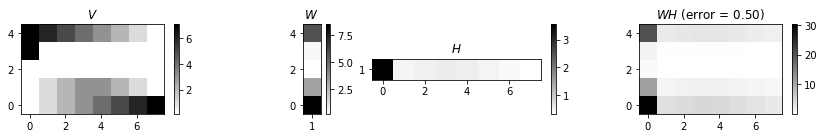

K = 2


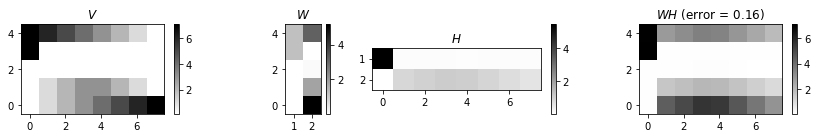

K = 3


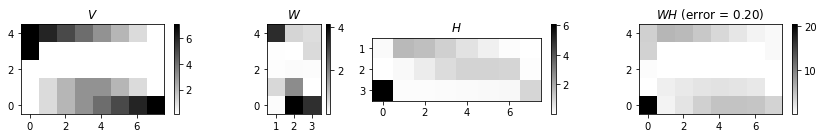

K = 4


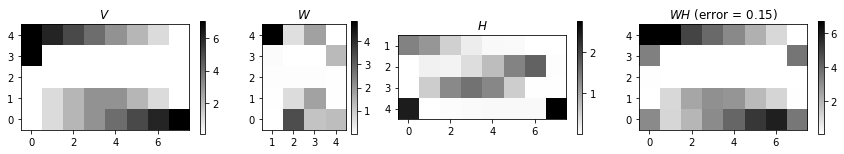

In [ ]:
niter = 100
K_set = np.array([1, 2, 3, 4])
for K in K_set: 
    print('K = %d'%K)
    W_init =  np.abs(np.random.rand(F,K))
    H_init = np.abs(np.random.rand(K,N)) 
    W, H, V_hat, cost = IS_NMF(V, K, niter=niter, W=W_init, H=H_init, verbose=False)
    plot_NMF(V, W, H, V_hat, cost[-1], figsize=(12,2), aspect='equal', wr=[1, .5, 1, 1])

Obviously, using $K=1$ is the most restrictive case, where only a single template vector is used to "explain" the entire matrix $V$. Increasing $K$, one obtains better approximations of $V\approx WH$. However, the matrices $W$ and $H$ are less structured and become harder to interpret.

In this example, K = 3 should be enough [1,1,0,0,0], [1,0,0,1,1], [0,0,0,0,1].

## Activity #2 - Unmixing a piano recording

We have a recording of the following piece of music played by a piano. It contains four piano notes.

<img src="./data/piano_recording.png" width="600px" align="middle" alt="FMP_C8_F20b">

<audio src="./data/piano.wav" type="audio/mpeg" controls="controls"></audio>


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FMP_C8_Audio_C-major-scale.mp3 to FMP_C8_Audio_C-major-scale.mp3
Saving midi_61.wav to midi_61.wav
Saving midi_65.wav to midi_65.wav
Saving midi_68.wav to midi_68.wav
Saving midi_72.wav to midi_72.wav
Saving piano.wav to piano.wav
Saving piano_recording.png to piano_recording.png


Text(0.5, 1.0, 'waveform')

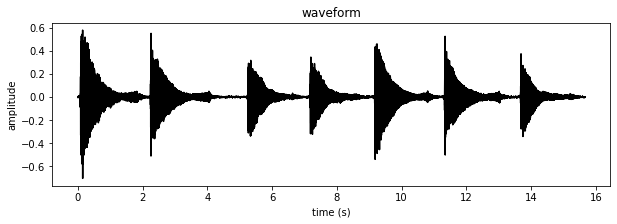

In [ ]:
# load and plot the waveform

x, Fs = librosa.load('piano.wav', sr=22050)

# wavefile = '../slides/images/jul_cut.wav'
# x, Fs = librosa.load(wavefile, sr=22050)

time = np.arange(0,x.shape[0]/Fs, 1/Fs)

plt.figure(figsize=(10,3))
plt.plot(time, x, 'k')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('waveform')

Text(0.5, 1.0, 'power spectrogram')

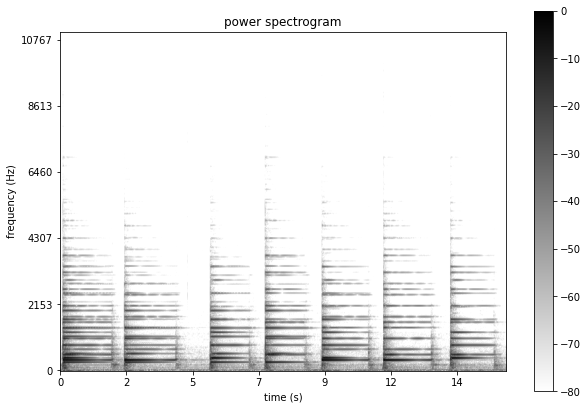

In [ ]:
# compute the STFT and the spectrogram

win_length = 1024
hop_length = 512
X = librosa.stft(x, n_fft=win_length, hop_length=hop_length, win_length=win_length, 
                 window='hann', center=True, pad_mode='constant')

V = np.abs(X)**2

freq = np.arange(0, V.shape[0])*Fs/win_length 
frames = np.arange(0, V.shape[1])*(hop_length/Fs)

plt.figure(figsize=(10,7))
plt.imshow(power_to_db(V), origin='lower', cmap='gray_r')
plt.yticks(np.arange(0, V.shape[0], 100), np.round(freq[0:-1:100]).astype(int))
plt.xticks(np.arange(0, V.shape[1], 100), np.round(frames[0:-1:100]).astype(int))
plt.colorbar()   
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.title('power spectrogram')

### Unmixing algorithm

We want to unmix this recording, that is separate the audio signal into multiple individual components.

We have to:

1. Compute an NMF on the **power** spectrogram:

$$\mathbf{V} = |\mathbf{X}|^{\odot 2} \approx \mathbf{W}\mathbf{H}$$

2. Compute rank-1 power spectrogram matrices: 

$$\hat{\mathbf{V}}_k = ({\mathbf{W}})_{:,k} ({\mathbf{H}})_{k,:}$$

3. Construct complex-valued STFT matrices using the phase of the mixture: 

$$\hat{\mathbf{X}}_k = \hat{\mathbf{V}}_k^{\odot 1/2} \odot \exp(j \arg(\mathbf{X})) $$

    (use ```np.angle()``` to compute the argument)

4. Compute the inverse STFT to recover a waveform signal for each individual component.

    (use ```librosa.istft(..., hop_length=hop_length, win_length=win_length, window='hann', center=True, length=x.shape[0]```, cf. [librosa documentation](http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.core.istft.html)).

In the following cell, we compute the NMF on the mixture power spectrogram.

Matrix V and matrices W and H after training using K = 8


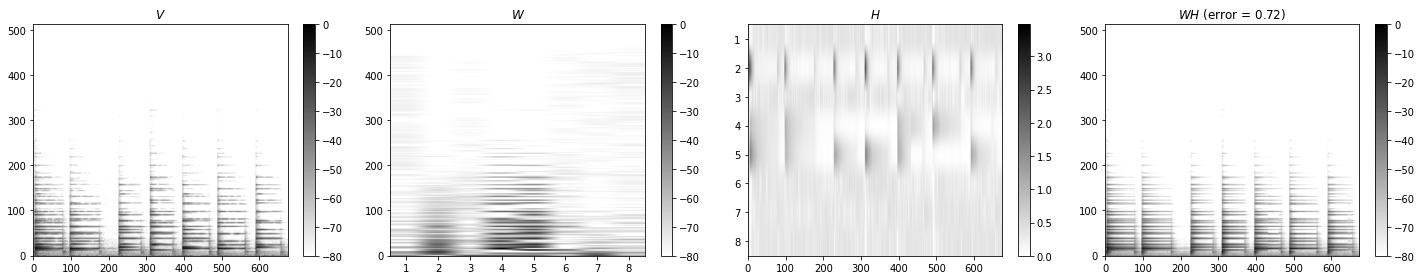

Text(0, 0.5, 'IS divergence')

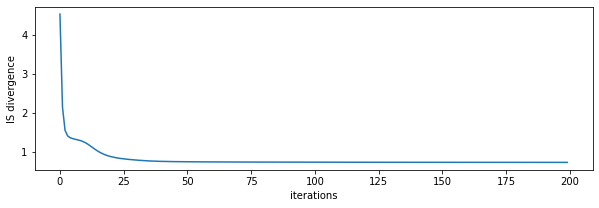

In [ ]:
# compute an NMF

F, N = V.shape
K = 8
niter = 200

W, H, V_hat, cost = IS_NMF(V, K, niter=niter, verbose=False)

print('Matrix V and matrices W and H after training using K = %d'%K)
plot_NMF(V, W, H, V_hat, cost[-1], figsize=(20,4), wr=[1, 1, 1, 1], power_spec=True)

plt.figure(figsize=(10,3))
plt.plot(cost)
plt.xlabel('iterations')
plt.ylabel('IS divergence')

You have now to complete the following cell to separate the individual audio components in the mixture. 

Hint: Try first to execute ```print(W[:,0].shape)``` and ```print(W[:,0,np.newaxis].shape)```. You will have to use this ```np.newaxis``` trick.

In [ ]:
x_hat = np.zeros((x.shape[0], K)) # will contain the waveforms of the components

wiener = False

for k in np.arange(K): 
    
    #### TO COMPLETE ####
    
    # compute a rank-one spectrogram
    V_hat_k = W[:, k, np.newaxis] @ H[np.newaxis, k, :]
    
    if wiener:
        # compute the STFT matrix using Wiener filtering
        X_hat_k = V_hat_k/(W@H) * X
    else:
        # compute the STFT matrix using the phase of the mixture
        X_hat_k = np.sqrt(V_hat_k) * np.exp(1j*np.angle(X))
    
    # compute the inverse STFT
    x_hat_k = librosa.istft(X_hat_k, hop_length=hop_length, win_length=win_length, 
                 window='hann', center=True, length=x.shape[0])
    
    # store the resulting waveform
    x_hat[:,k] = x_hat_k    

We can now listen to and look at the separated components in the following cell. This is great, right?

You can play with the rank of the factorization, and listen to the reconstructed signals. 

Depending on the chosen rank, some components may capture the individual harmonic notes in the mixture, other components may capture percussive sounds, such as the attacks of the notes, or the release of the sustain pedal, which is clearly audible in the mixture, and some components may also simply correspond to low-amplitude noise.

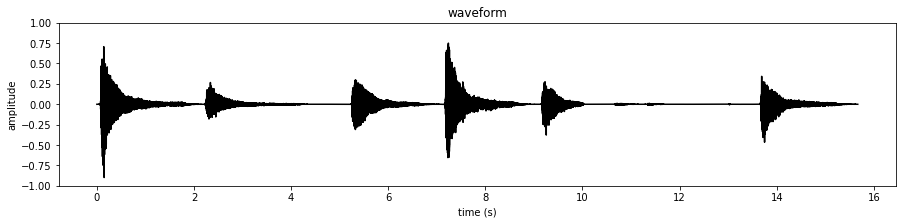

In [ ]:
comp_num = 4 # choose a component number

plt.figure(figsize=(15,3))
plt.plot(time, x_hat[:,comp_num], 'k') # plot this component
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('waveform')
plt.ylim([-1,1])

ipd.Audio(x_hat[:,comp_num], rate=Fs) # listen to this component

Verify if by summing the individual components (in the time domain) you recover the original mixture signal.

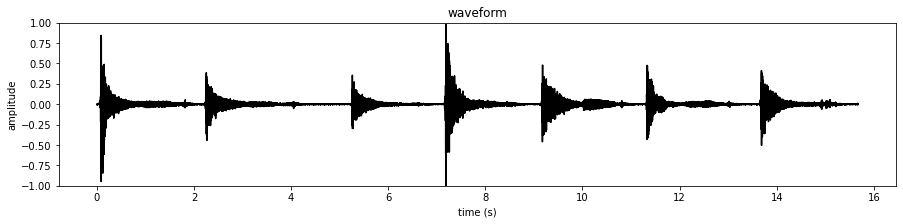

In [ ]:
x_hat_sum = np.sum(x_hat, 1)

plt.figure(figsize=(15,3))
plt.plot(time, x_hat_sum - x, 'k') # plot this component
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('waveform')
plt.ylim([-1,1])

ipd.Audio(x_hat_sum, rate=Fs) # listen to this component

To be able to recover the mixture by summing the individual components, we should replace step number 3 in the above algorithm by another process called Wiener filtering:

$$\hat{\mathbf{X}}_k = \frac{\hat{\mathbf{V}}_k}{\sum_{k=1}^K \hat{\mathbf{V}}_k} \odot \mathbf{X}, $$

where division is element wise. Remember that $\sum_{k=1}^K \hat{\mathbf{V}}_k = \mathbf{W}\mathbf{H}$.

Modify your implementation to use Wiener filtering.

You can also test the method on different audio mixtures.